In [1]:
import torch
import torch.nn as nn
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Adapted from  https://github.com/TianhongDai/integrated-gradient-pytorch
#and https://github.com/A-LinCui/Adversarial_Patch_Attack

class Normalize(nn.Module):
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std


norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
weights = ResNet50_Weights.DEFAULT


model = nn.Sequential(
    norm_layer,
    resnet50(weights=weights))


model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)

model = model.eval()


In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)#,figsize=(15, 10))
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


#img = read_image('images/black_swan.jpeg')
#img = read_image('images/macaw.jpg')  

img = read_image('images/tank.jpg')  
        
transform = T.Compose([
    T.Resize((224, 224)),
    T.Normalize(mean=[0, 0, 0], std=[255.0, 255.0, 255.0]),
])

batch = transform(img.float()).unsqueeze(0)
        
    




In [3]:
batch = batch.to(device)
prediction = model(batch).squeeze(0).softmax(0)

class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")
print("Top-K labels:",prediction.topk(5)[1].cpu().numpy())

tank: 45.4%
Top-K labels: [847 471 408 744 586]


In [4]:
import numpy as np
from torch.autograd import Variable

def patch_initialization(patch_type='rectangle', image_size=(3, 224, 224), noise_percentage=0.03):
    if patch_type == 'rectangle':
        mask_length = int((noise_percentage * image_size[1] * image_size[2])**0.45)
        patch = np.random.rand(image_size[0], mask_length, mask_length)
    return patch


# Generate the mask and apply the patch
# TODO: Add circle type
def mask_generation(mask_type='rectangle', patch=None, image_size=(3, 224, 224)):
    applied_patch = np.zeros(image_size)
    if mask_type == 'rectangle':
        # patch rotation
        rotation_angle = np.random.choice(4)
        for i in range(patch.shape[0]):
            patch[i] = np.rot90(patch[i], rotation_angle)  # The actual rotation angle is rotation_angle * 90
        # patch location
        x_location, y_location = np.random.randint(low=0, high=image_size[1]-patch.shape[1]), np.random.randint(low=0, high=image_size[2]-patch.shape[2])
        for i in range(patch.shape[0]):
            applied_patch[:, x_location:x_location + patch.shape[1], y_location:y_location + patch.shape[2]] = patch
    mask = applied_patch.copy()
    mask[mask != 0] = 1.0
    return applied_patch, mask, x_location, y_location



def patch_attack(image, applied_patch, mask, target, probability_threshold, model, lr=1, max_iteration=100):
    model.eval()
    applied_patch = torch.from_numpy(applied_patch)
    mask = torch.from_numpy(mask)
    target_probability, count = 0, 0
    perturbated_image = torch.mul(mask.type(torch.FloatTensor), applied_patch.type(torch.FloatTensor)) + torch.mul((1 - mask.type(torch.FloatTensor)), image.type(torch.FloatTensor))
    while target_probability < probability_threshold and count < max_iteration:
        count += 1
        # Optimize the patch
        perturbated_image = Variable(perturbated_image.data, requires_grad=True)
        per_image = perturbated_image
        per_image = per_image.cuda()
        output = model(per_image)
        target_log_softmax = torch.nn.functional.log_softmax(output, dim=1)[0][target]
        target_log_softmax.backward()
        patch_grad = perturbated_image.grad.clone().cpu()
        perturbated_image.grad.data.zero_()
        applied_patch = lr * patch_grad + applied_patch.type(torch.FloatTensor)
        applied_patch = torch.clamp(applied_patch, min=-3, max=3)
        # Test the patch
        perturbated_image = torch.mul(mask.type(torch.FloatTensor), applied_patch.type(torch.FloatTensor)) + torch.mul((1-mask.type(torch.FloatTensor)), image.type(torch.FloatTensor))
        perturbated_image = torch.clamp(perturbated_image, min=-3, max=3)
        perturbated_image = perturbated_image.cuda()
        output = model(perturbated_image)
        target_probability = torch.nn.functional.softmax(output, dim=1).data[0][target]
    perturbated_image = perturbated_image.cpu().numpy()
    applied_patch = applied_patch.cpu().numpy()
    return perturbated_image, applied_patch



target = 859
probability_threshold = 0.9
noise_percentage = 0.1
lr = 1.0
max_iteration=1000
patch_type = 'rectangle'
patch = patch_initialization(patch_type, image_size=(3, 224, 224), noise_percentage=noise_percentage)
print('The shape of the patch is', patch.shape)
applied_patch, mask, x_location, y_location = mask_generation(patch_type, patch, image_size=(3, 224, 224))
#print(patch.shape,applied_patch.shape)
perturbated_image, applied_patch = patch_attack(batch, applied_patch, mask, target, probability_threshold, model, lr, max_iteration)


The shape of the patch is (3, 46, 46)


In [5]:
prediction = model(torch.from_numpy(perturbated_image)).squeeze(0).softmax(0)
class_idPert = prediction.argmax().item()
score = prediction[class_idPert].item()
category_name = weights.meta["categories"][class_idPert]

print("Attacked Label: "f"{category_name} {100 * score:.1f}%")

Attacked Label: toaster 90.1%


In [6]:
import torch.nn.functional as F


def pre_processing(obs):
    #obs_tensor = process(torch.tensor(obs,requires_grad=True)).to(device)
    obs_tensor = torch.tensor(obs,requires_grad=True).to(device)
    obs_tensor = obs_tensor.clone().detach().requires_grad_(True)  
    return obs_tensor


def calculate_outputs_and_gradients(inputs, model, target_label_idx, cuda=True):
    # do the pre-processing
    predict_idx = None
    gradients = []
    for input in inputs:
        input = pre_processing(input)
        #print(input,input.shape)
        if input.dim() == 4:
            output = model(input.float())
        else:
            output = model(input.float().unsqueeze(0))
        output = F.softmax(output, dim=1)
        #print(output,output.shape)
        if target_label_idx is None:
            target_label_idx = torch.argmax(output, 1).item()
        index = np.ones((output.size()[0], 1)) * target_label_idx
        index = torch.tensor(index, dtype=torch.int64)
        if cuda:
            index = index.cuda()
        output = output.gather(1, index)
        # clear grad
        model.zero_grad()
        output.backward()
        gradient = input.grad.detach().cpu().numpy()[0]
        gradients.append(gradient)
    gradients = np.array(gradients)
    return gradients, target_label_idx


def integrated_gradients(inputs, model, target_label_idx, predict_and_gradients, baseline, steps=50, cuda=True):
    if baseline is None:
        baseline = 0 * inputs 
    # scale inputs and compute gradients
    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads, _ = predict_and_gradients(scaled_inputs, model, target_label_idx, cuda)
    avg_grads = np.average(grads[:-1], axis=0)
    delta_X = (pre_processing(inputs) - pre_processing(baseline)).detach().squeeze(0).cpu().numpy()
    integrated_grad = delta_X * avg_grads
    return integrated_grad

def random_baseline_integrated_gradients(inputs, model, target_label_idx, predict_and_gradients, steps, num_random_trials, cuda=True):
    all_intgrads = []
    for i in range(num_random_trials):
        integrated_grad = integrated_gradients(inputs, model, target_label_idx, predict_and_gradients, \
                                                baseline=(np.random.random(inputs.shape)), steps=steps, cuda=cuda)
        all_intgrads.append(integrated_grad)
    avg_intgrads = np.average(np.array(all_intgrads), axis=0)
    return avg_intgrads


batchImg = batch.cpu().numpy()
gradients, label_index = calculate_outputs_and_gradients(batchImg, model, None)
attributions = random_baseline_integrated_gradients(batchImg, model, label_index, calculate_outputs_and_gradients,steps=50, num_random_trials=10)



In [7]:
G = [0, 255, 0]
R = [255, 0, 0]

def convert_to_gray_scale(attributions):
    return np.average(attributions, axis=2)

def linear_transform(attributions, clip_above_percentile=99.9, clip_below_percentile=70.0, low=0.2, plot_distribution=False):
    m = compute_threshold_by_top_percentage(attributions, percentage=100-clip_above_percentile, plot_distribution=plot_distribution)
    e = compute_threshold_by_top_percentage(attributions, percentage=100-clip_below_percentile, plot_distribution=plot_distribution)
    transformed = (1 - low) * (np.abs(attributions) - e) / (m - e) + low
    transformed *= np.sign(attributions)
    transformed *= (transformed >= low)
    transformed = np.clip(transformed, 0.0, 1.0)
    return transformed

def compute_threshold_by_top_percentage(attributions, percentage=60, plot_distribution=True):
    if percentage < 0 or percentage > 100:
        raise ValueError('percentage must be in [0, 100]')
    if percentage == 100:
        return np.min(attributions)
    flat_attributions = attributions.flatten()
    attribution_sum = np.sum(flat_attributions)
    sorted_attributions = np.sort(np.abs(flat_attributions))[::-1]
    cum_sum = 100.0 * np.cumsum(sorted_attributions) / attribution_sum
    threshold_idx = np.where(cum_sum >= percentage)[0][0]
    threshold = sorted_attributions[threshold_idx]
    if plot_distribution:
        raise NotImplementedError 
    return threshold

def polarity_function(attributions, polarity):
    if polarity == 'positive':
        return np.clip(attributions, 0, 1)
    elif polarity == 'negative':
        return np.clip(attributions, -1, 0)
    else:
        raise NotImplementedError

def overlay_function(attributions, image):
    return np.clip(0.7 * image + 0.5 * attributions, 0, 255)

def visualize(attributions, image, positive_channel=G, negative_channel=R, polarity='positive', \
                clip_above_percentile=99.9, clip_below_percentile=0, morphological_cleanup=False, \
                structure=np.ones((3, 3)), outlines=False, outlines_component_percentage=90, overlay=True, \
                mask_mode=False, plot_distribution=False):
    if polarity == 'both':
        raise NotImplementedError

    elif polarity == 'positive':
        attributions = polarity_function(attributions, polarity=polarity)
        channel = positive_channel
    
    # convert the attributions to the gray scale
    attributions = convert_to_gray_scale(attributions)
    attributions = linear_transform(attributions, clip_above_percentile, clip_below_percentile, 0.0, plot_distribution=plot_distribution)
    attributions_mask = attributions.copy()
    if morphological_cleanup:
        raise NotImplementedError
    if outlines:
        raise NotImplementedError
    attributions = np.expand_dims(attributions, 2) * channel
    if overlay:
        if mask_mode == False:
            attributions = overlay_function(attributions, image)
        else:
            attributions = np.expand_dims(attributions_mask, 2)
            attributions = np.clip(attributions * image, 0, 255)
            attributions = attributions[:, :, (2, 1, 0)]
    return attributions


img_integrated_gradient = visualize(np.transpose(attributions,(1,2,0)), np.transpose(batchImg[0],(1,2,0)), clip_above_percentile=95.0, clip_below_percentile=0, overlay=False)
img_integrated_gradient = img_integrated_gradient/np.max(img_integrated_gradient)
img_intG = torch.tensor(img_integrated_gradient).permute(2, 0, 1)

In [8]:
import scipy.stats as st
import pandas as pd


def randomFilter(x0):
    s = np.random.uniform(0,1)
    if x0 >= s:
        return 1, s
    else:
        return 0 , s



def processAttr(attr):
    x = np.array(attr).flatten()
    params = st.gennorm.fit(x)
    
    return attr, params
    
    
def ABCSamples(img,attr,removalPerct,power,sampleSize):
    attr,params = processAttr(attr)
    sampleShape = img.shape
    l = list(sampleShape)
    l.insert(0,sampleSize)
    sampleShape = tuple(l)
    
    sampleNp = np.zeros(sampleShape)
    samplePlaceHolder = np.zeros(sampleShape)
    
    for i in range(sampleSize):
        sampleNp[i] = img
    
    count = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            cd0 = st.gennorm.cdf(attr[i][j],beta=params[0],loc=params[1],scale=params[2])
            x0 = cd0**power;
                        
            for l in range(sampleSize):
                filterFlag, s = randomFilter(x0)
                if filterFlag == 1:
                    samplePlaceHolder[l][i][j][0] = 1
                    count = count + 1
    
    tot = img.shape[0]*img.shape[1]*sampleSize


    #previous paper has already hinted to an optimal removal strategy we want to remove 0.1% only!
    optimalRemoval = removalPerct
    currentRemoval = count*100.0/tot

    
    ratio = optimalRemoval/currentRemoval

    updatedCount = 0
    for l in range(sampleSize):
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if samplePlaceHolder[l][i][j][0] == 1:
                    s = np.random.uniform(0,1)
                    if s <= ratio:
                        sampleNp[l][i][j][0]=0
                        sampleNp[l][i][j][1]=0
                        sampleNp[l][i][j][2]=0
                        updatedCount = updatedCount+1

    return sampleNp


from scipy.stats import entropy
from scipy.special import softmax

def ABC(img,OriginalLabel,attr,removalPerct=4.0,power=70,sampleSize=100):
    #Original label is not required here#
    
    img = np.transpose(img,(1,2,0))
    attr = np.abs(np.transpose(attr,(1,2,0)))
    attr = attr[:,:,0]+attr[:,:,1]+attr[:,:,2]
    samples = ABCSamples(img,attr,removalPerct,power,sampleSize)
    samples = np.transpose(samples,(0,3,1,2))
  
    sampleTensor = torch.tensor(samples).float()
    
    prediction = model(sampleTensor)

    output = F.softmax(prediction, dim=1)
    output = torch.argmax(output, 1)
    ABCVal = 0
    for i in output:
        if i == OriginalLabel:
            ABCVal += 1
    
    ABCVal = ABCVal/output.shape[0]
    return samples, ABCVal
  
    



In [9]:
    
predictionOrig = model(batch[0]).squeeze(0).softmax(0)
class_idOrig = predictionOrig.argmax().item()
samples , abcVal = ABC(batch[0].cpu().detach().numpy(),class_idOrig,attributions)
samples1 = torch.tensor(samples[0])



In [10]:

predictionPert = model(torch.from_numpy(perturbated_image)).squeeze(0).softmax(0)
class_idPert = predictionPert.argmax().item()


pertImg = perturbated_image.copy()
gradientsPert, label_indexPert = calculate_outputs_and_gradients(pertImg, model, class_idPert)
attributionsPert = random_baseline_integrated_gradients(pertImg, model, label_indexPert, calculate_outputs_and_gradients,steps=50, num_random_trials=10)

samplesPert, abcValPert = ABC(perturbated_image[0],class_idPert,attributionsPert)

samplesPert1 = torch.tensor(samplesPert[0])
img_integrated_gradientPert = visualize(np.transpose(attributionsPert,(1,2,0)), np.transpose(batchImg[0],(1,2,0)), clip_above_percentile=95.0, clip_below_percentile=0, overlay=False)
img_integrated_gradientPert = img_integrated_gradientPert/np.max(img_integrated_gradientPert)



ABC Metric Original:  1.0 , Class :  tank


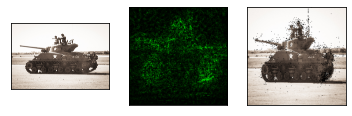

In [11]:
print("ABC Metric Original: ", abcVal, ", Class : ",  weights.meta["categories"][class_id])
img_intG = torch.tensor(img_integrated_gradient).permute(2, 0, 1)
show([img,img_intG,samples1])


ABC Metric Attacked:  0.0 , Class :  toaster


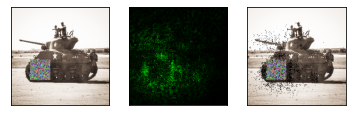

In [12]:
print("ABC Metric Attacked: ", abcValPert, ", Class : ",  weights.meta["categories"][class_idPert])
img_intGPert = torch.tensor(img_integrated_gradientPert).permute(2, 0, 1)
show([torch.from_numpy(perturbated_image[0]),img_intGPert,samplesPert1])

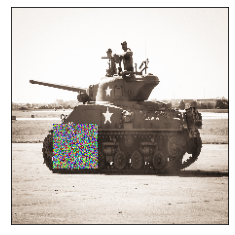

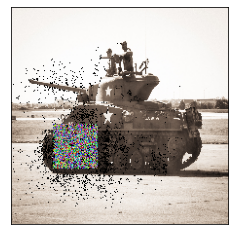

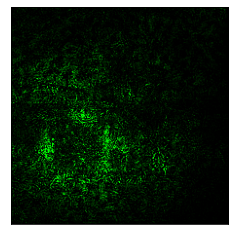

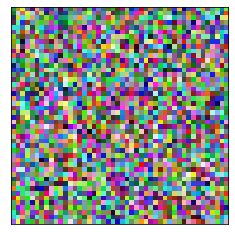

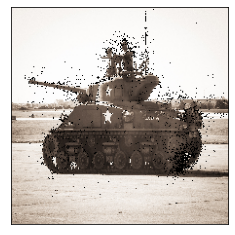

In [13]:
show([torch.from_numpy(perturbated_image[0])])

show([samplesPert1])

show([img_intGPert])

show([torch.from_numpy(patch)])

show([samples1])